In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

2024-04-01 17:38:27.567893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 17:38:27.568015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 17:38:27.694227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
breast_img = glob.glob('/kaggle/input/ns-idc-data/NS_IDC_Data/F/*/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/ns-idc-data/NS_IDC_Data/F/0/13591_idx5_x2951_y651_class0.png
/kaggle/input/ns-idc-data/NS_IDC_Data/F/0/13666_idx5_x1151_y251_class0.png
/kaggle/input/ns-idc-data/NS_IDC_Data/F/0/13024_idx5_x551_y601_class0.png


In [3]:
len(breast_img)

20000

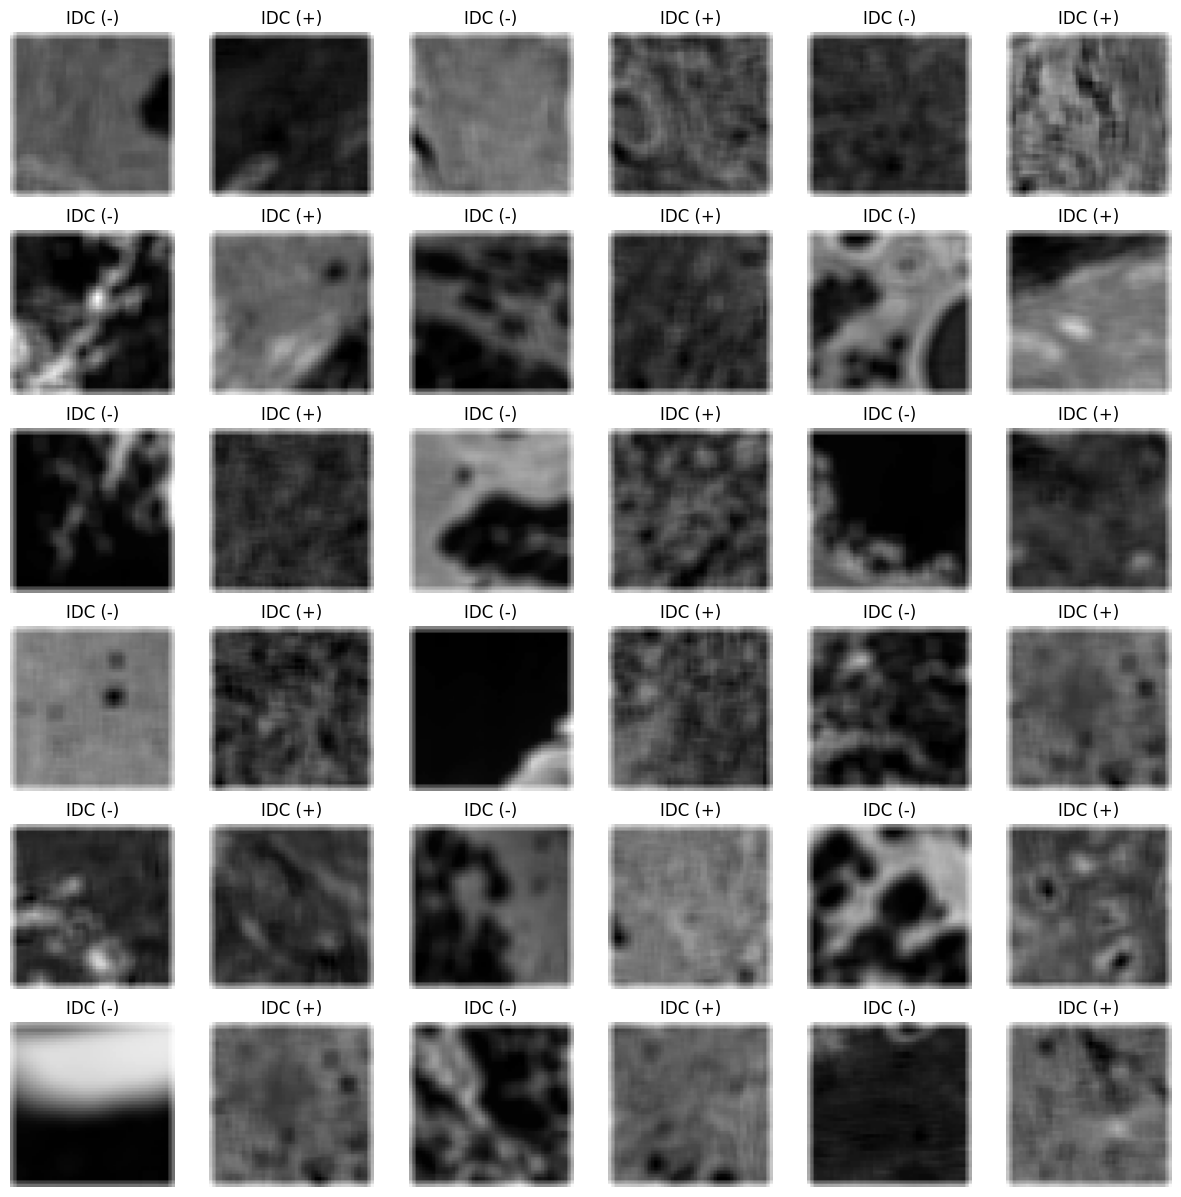

In [4]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
        
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('IDC (-)')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [5]:
y = []
for img in breast_img:
    if img.endswith('class0.png'):
        y.append(0)
    elif img.endswith('class1.png'):
        y.append(1)

print(len(y))

images_df = pd.DataFrame()
images_df["images"] = breast_img
images_df["labels"] = y
print(images_df.head())
print()

def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a.shape))
describeData(cv2.imread(breast_img[0]),images_df["labels"])

20000
                                              images  labels
0  /kaggle/input/ns-idc-data/NS_IDC_Data/F/0/1359...       0
1  /kaggle/input/ns-idc-data/NS_IDC_Data/F/0/1366...       0
2  /kaggle/input/ns-idc-data/NS_IDC_Data/F/0/1302...       0
3  /kaggle/input/ns-idc-data/NS_IDC_Data/F/0/1026...       0
4  /kaggle/input/ns-idc-data/NS_IDC_Data/F/0/1025...       0

Total number of images: 50
Number of IDC(-) Images: 10000
Number of IDC(+) Images: 10000
Image shape (Width, Height, Channels): (50, 50, 3)


In [6]:
from sklearn.model_selection import train_test_split


# Step 1: Read the image paths and labels from the DataFrame
X_paths = images_df['images'].tolist()
y = images_df['labels'].tolist()

# Define a function to load and preprocess images
def load_images(image_paths):
    images = []
    for path in image_paths:
        image = cv2.imread(path) 
        #image = cv2.resize(image,(50, 50), interpolation = cv2.INTER_LINEAR)
        image = cv2.resize(image, (50, 50), interpolation = cv2.INTER_AREA)
        image = image / 255.0
        # Optionally, preprocess the images here (resize, normalize, etc.)
        images.append(image)
    return images

# Load images for train and test sets
X = load_images(X_paths)

In [7]:
# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [8]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", y_train.shape)
print("Testing Data Shape:", y_test.shape)

Training Data Shape: (16000, 50, 50, 3)
Testing Data Shape: (4000, 50, 50, 3)
Training Data Shape: (16000,)
Testing Data Shape: (4000,)


# MODLING

In [9]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.models import Model

# VGG16 MODEL

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16


vgg_model=VGG16(input_shape=(50,50,3),include_top=False)
x=Flatten()(vgg_model.output)
prediction=Dense(2,activation='softmax')(x)
model=Model(inputs=vgg_model.input,outputs=prediction)
#model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
  5/250 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.4754 - loss: 0.7268 

I0000 00:00:1711993208.236718      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - accuracy: 0.6613 - loss: 0.6140 - val_accuracy: 0.7147 - val_loss: 0.5632
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7269 - loss: 0.5380 - val_accuracy: 0.6975 - val_loss: 0.5674
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7445 - loss: 0.5182 - val_accuracy: 0.7377 - val_loss: 0.5241
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7553 - loss: 0.4943 - val_accuracy: 0.7630 - val_loss: 0.4927
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7729 - loss: 0.4703 - val_accuracy: 0.7660 - val_loss: 0.4879
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7933 - loss: 0.4369 - val_accuracy: 0.7515 - val_loss: 0.5157
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8251 - loss: 0.3899 - val_accuracy: 0.7508 - val_loss: 0.5390
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8495 - loss: 0.3468 - val_accuracy: 0.75

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


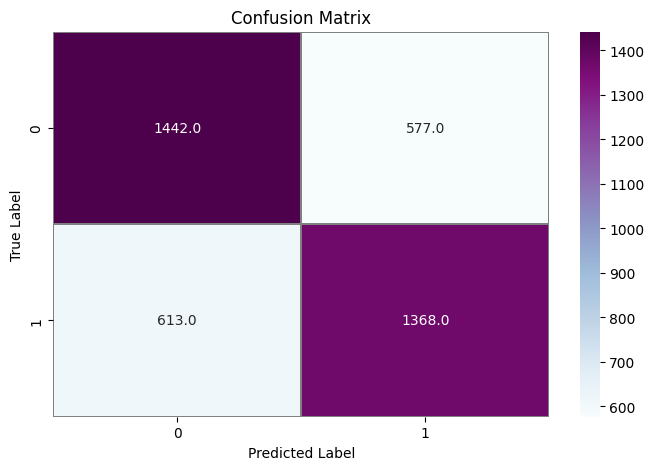

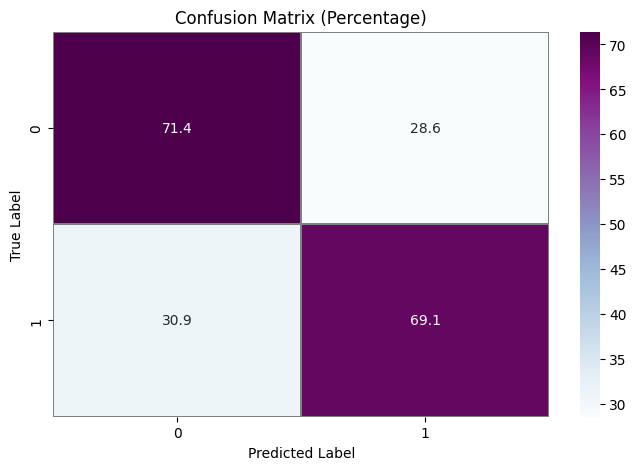

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7069 - loss: 2.0411
Test Loss: 2.025191307067871
Test Accuracy: 0.7024999856948853


              precision    recall  f1-score   support

           0       0.70      0.71      0.71      2019
           1       0.70      0.69      0.70      1981

    accuracy                           0.70      4000
   macro avg       0.70      0.70      0.70      4000
weighted avg       0.70      0.70      0.70      4000



In [12]:
from sklearn.metrics import accuracy_score , confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

#  VGG19 MODEL

In [13]:
from tensorflow.keras.applications import VGG19

# Load the pre-trained VGG19 model (without the top classification layer)
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the VGG19 base model
x = Flatten()(vgg_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=vgg_model.input, outputs=prediction)
#model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.6367 - loss: 0.6506 - val_accuracy: 0.7420 - val_loss: 0.5314
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7257 - loss: 0.5526 - val_accuracy: 0.6873 - val_loss: 0.6186
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7255 - loss: 0.5447 - val_accuracy: 0.7508 - val_loss: 0.5116
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7469 - loss: 0.5130 - val_accuracy: 0.7508 - val_loss: 0.5185
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7517 - loss: 0.5106 - val_accuracy: 0.7460 - val_loss: 0.5168
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7633 - loss: 0.4927 - val_accuracy: 0.7567 - val_loss: 0.4945
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7670 - loss: 0.4857 - val_accuracy: 0.7400 - val_loss: 0.5198
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7792 - loss: 0.4679 - 

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


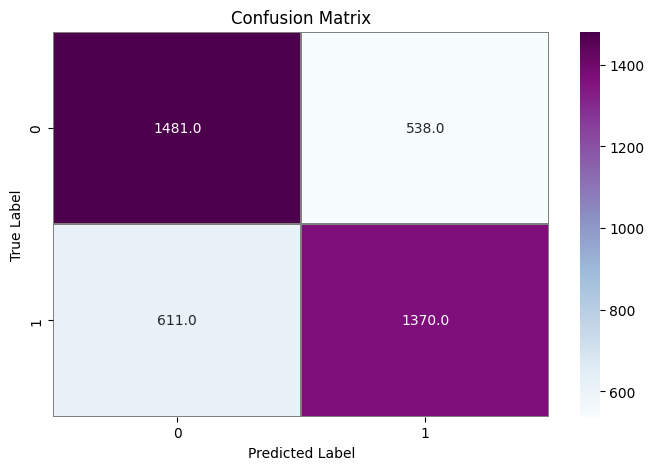

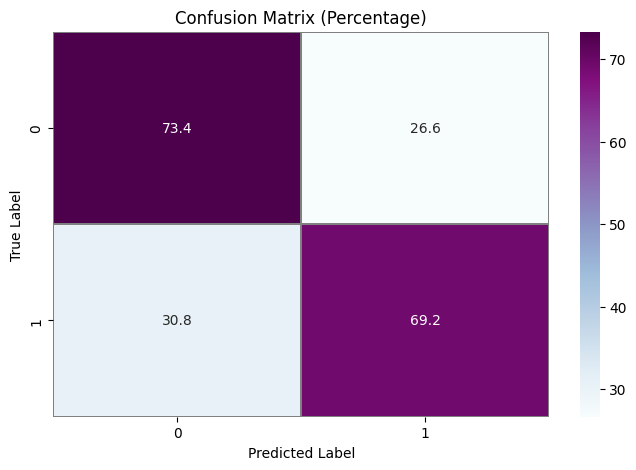

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7155 - loss: 1.9835
Test Loss: 1.9688864946365356
Test Accuracy: 0.7127500176429749


              precision    recall  f1-score   support

           0       0.71      0.73      0.72      2019
           1       0.72      0.69      0.70      1981

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000



In [15]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# ResNet50

In [16]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model (without the top classification layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the ResNet50 base model
x = Flatten()(resnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=resnet_model.input, outputs=prediction)
#model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 82ms/step - accuracy: 0.6619 - loss: 0.8548 - val_accuracy: 0.5048 - val_loss: 0.9973
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.7844 - loss: 0.5110 - val_accuracy: 0.5045 - val_loss: 3.1812
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8513 - loss: 0.3536 - val_accuracy: 0.5023 - val_loss: 2.3172
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9309 - loss: 0.1911 - val_accuracy: 0.6410 - val_loss: 0.7222
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9644 - loss: 0.1043 - val_accuracy: 0.6917 - val_loss: 0.7250
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9741 - loss: 0.0804 - val_accuracy: 0.7235 - val_loss: 0.7794
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9769 - loss: 0.0679 - val_accuracy: 0.7390 - val_loss: 0.8169
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9713 - loss: 0.0787 - 

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


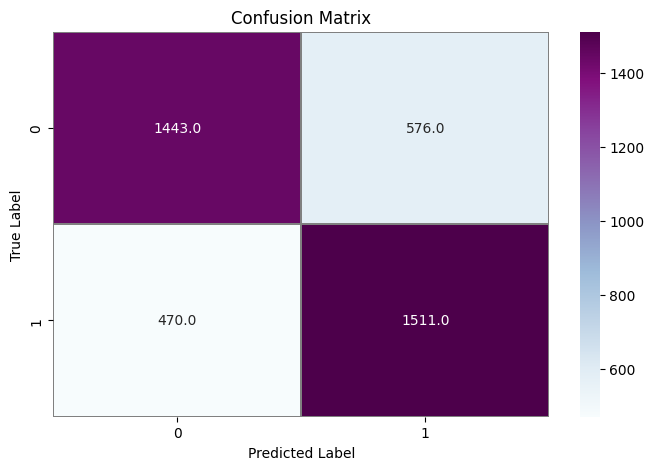

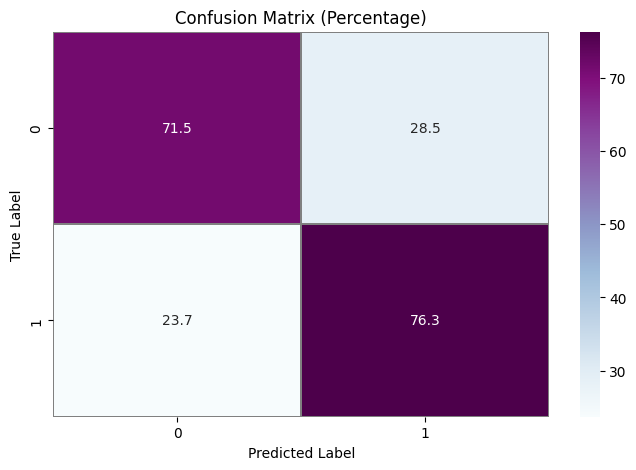

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7379 - loss: 4.0739
Test Loss: 4.193431854248047
Test Accuracy: 0.7384999990463257


              precision    recall  f1-score   support

           0       0.75      0.71      0.73      2019
           1       0.72      0.76      0.74      1981

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



In [18]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# ResNet152

In [19]:
from tensorflow.keras.applications import ResNet152


# Load the pre-trained ResNet152 model (without the top classification layer)
resnet_model = ResNet152(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the ResNet152 base model
x = Flatten()(resnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=resnet_model.input, outputs=prediction)

#model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 210s 200ms/step - accuracy: 0.6642 - loss: 0.8847 - val_accuracy: 0.5048 - val_loss: 2.6593
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.7831 - loss: 0.5221 - val_accuracy: 0.5042 - val_loss: 1.9307
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.8078 - loss: 0.4468 - val_accuracy: 0.5048 - val_loss: 1.2891
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.8647 - loss: 0.3528 - val_accuracy: 0.5555 - val_loss: 0.8984
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.9084 - loss: 0.2512 - val_accuracy: 0.6898 - val_loss: 0.6988
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.9418 - loss: 0.1526 - val_accuracy: 0.7427 - val_loss: 0.7127
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.9699 - loss: 0.0880 - val_accuracy: 0.7565 - val_loss: 0.7419
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - accuracy: 0.9749 - loss: 

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step


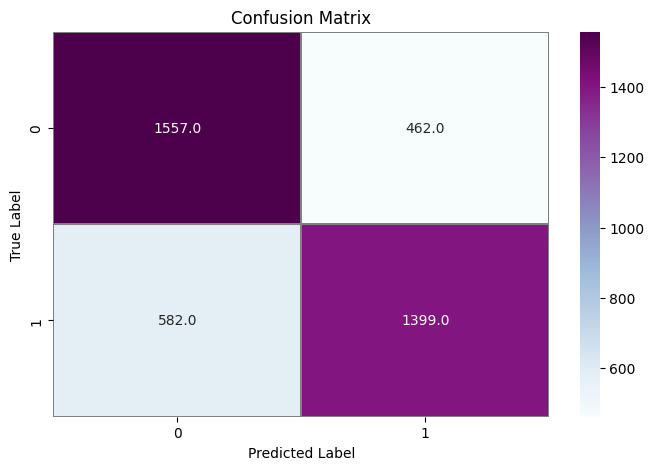

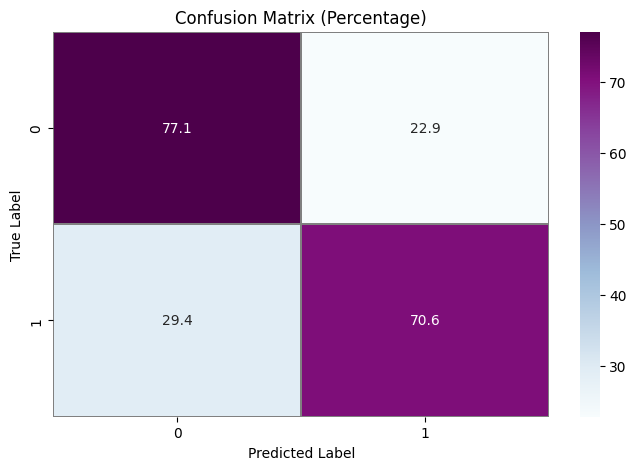

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7393 - loss: 1.3166
Test Loss: 1.3493291139602661
Test Accuracy: 0.7390000224113464


              precision    recall  f1-score   support

           0       0.73      0.77      0.75      2019
           1       0.75      0.71      0.73      1981

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



In [21]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# DenseNet121 Model

In [22]:
from tensorflow.keras.applications import DenseNet121

# Load the pre-trained DenseNet121 model (without the top classification layer)
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the DenseNet121 base model
x = Flatten()(densenet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=densenet_model.input, outputs=prediction)
#model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 146ms/step - accuracy: 0.6789 - loss: 0.6821 - val_accuracy: 0.6340 - val_loss: 0.6709
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.7925 - loss: 0.4616 - val_accuracy: 0.7430 - val_loss: 0.5343
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.8210 - loss: 0.3989 - val_accuracy: 0.7653 - val_loss: 0.5568
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.8629 - loss: 0.3246 - val_accuracy: 0.7310 - val_loss: 0.6119
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.8983 - loss: 0.2528 - val_accuracy: 0.6705 - val_loss: 0.7978
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9352 - loss: 0.1718 - val_accuracy: 0.7287 - val_loss: 0.8162
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9441 - loss: 0.1473 - val_accuracy: 0.7322 - val_loss: 0.8473
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9614 - loss: 0.1078 

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step


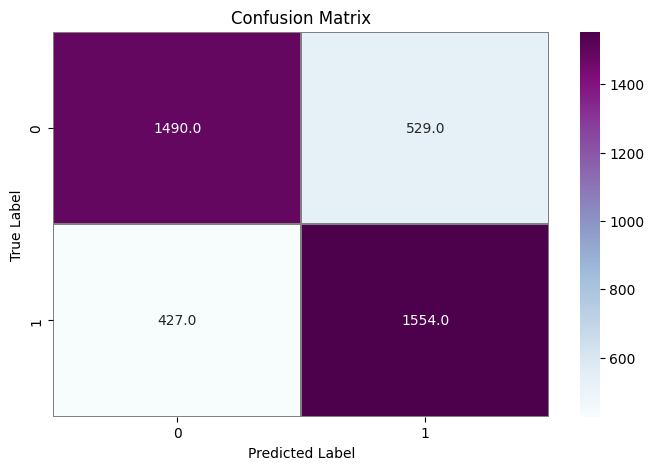

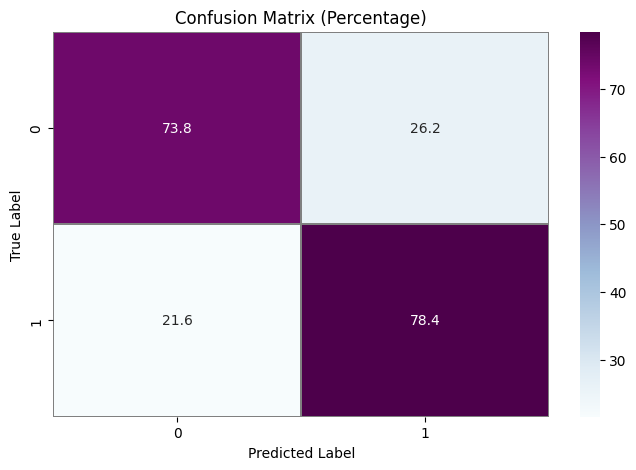

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7636 - loss: 1.4557
Test Loss: 1.5289714336395264
Test Accuracy: 0.7609999775886536


              precision    recall  f1-score   support

           0       0.78      0.74      0.76      2019
           1       0.75      0.78      0.76      1981

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [24]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# EfficientNetB0

In [25]:
from tensorflow.keras.applications import EfficientNetB0

# Load the pre-trained EfficientNetB0 model (without the top classification layer)
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the EfficientNetB0 base model
x = Flatten()(efficientnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=efficientnet_model.input, outputs=prediction)
#model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 78ms/step - accuracy: 0.6535 - loss: 0.7068 - val_accuracy: 0.5048 - val_loss: 0.9265
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7677 - loss: 0.4936 - val_accuracy: 0.4818 - val_loss: 0.8339
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8147 - loss: 0.4093 - val_accuracy: 0.5950 - val_loss: 0.8203
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8453 - loss: 0.3588 - val_accuracy: 0.7278 - val_loss: 0.6045
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8720 - loss: 0.3076 - val_accuracy: 0.7343 - val_loss: 0.5856
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9005 - loss: 0.2563 - val_accuracy: 0.7280 - val_loss: 0.6142
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9177 - loss: 0.2214 - val_accuracy: 0.7395 - val_loss: 0.6493
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9257 - loss: 0.1980 - val_acc

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


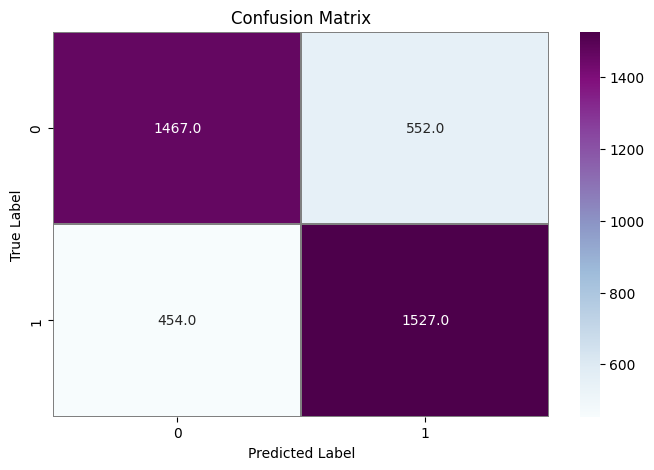

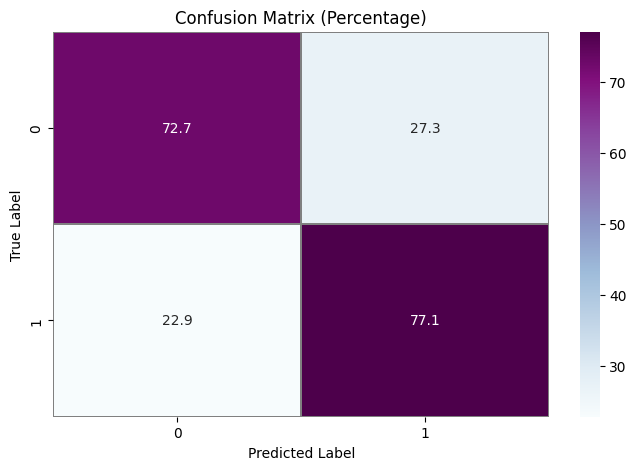

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7635 - loss: 1.2399
Test Loss: 1.308301568031311
Test Accuracy: 0.7484999895095825


              precision    recall  f1-score   support

           0       0.76      0.73      0.74      2019
           1       0.73      0.77      0.75      1981

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



In [27]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# MobileNetV2 Model

In [28]:
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained MobileNetV2 model (without the top classification layer)
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the MobileNetV2 base model
x = Flatten()(mobilenet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=mobilenet_model.input, outputs=prediction)
#model.summary()

/tmp/ipykernel_34/1739306031.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 50, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - accuracy: 0.6549 - loss: 0.7448 - val_accuracy: 0.5592 - val_loss: 0.7905
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7527 - loss: 0.5190 - val_accuracy: 0.5335 - val_loss: 1.0987
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7770 - loss: 0.4763 - val_accuracy: 0.5727 - val_loss: 0.9573
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8088 - loss: 0.4131 - val_accuracy: 0.6043 - val_loss: 0.8730
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8315 - loss: 0.3786 - val_accuracy: 0.5968 - val_loss: 1.0764
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8521 - loss: 0.3388 - val_accuracy: 0.5978 - val_loss: 0.9964
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8646 - loss: 0.3116 - val_accuracy: 0.6288 - val_loss: 1.0003
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8921 - loss: 0.2592 - val_acc

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


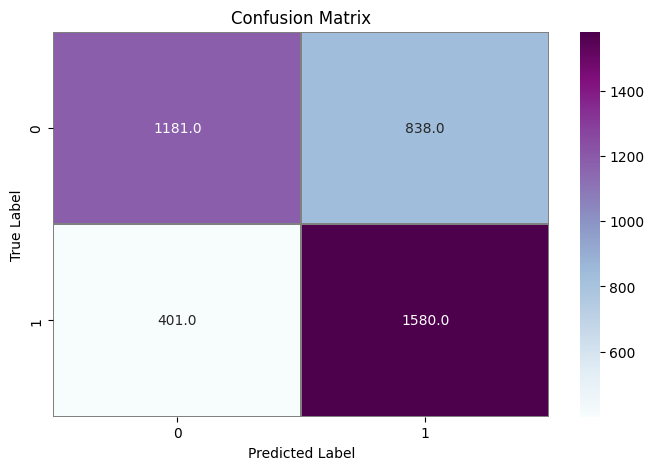

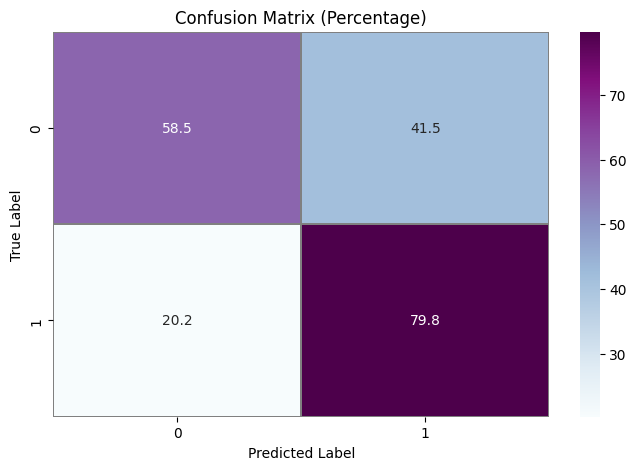

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6968 - loss: 1.5988
Test Loss: 1.644464373588562
Test Accuracy: 0.6902499794960022


              precision    recall  f1-score   support

           0       0.75      0.58      0.66      2019
           1       0.65      0.80      0.72      1981

    accuracy                           0.69      4000
   macro avg       0.70      0.69      0.69      4000
weighted avg       0.70      0.69      0.69      4000



In [30]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))